<a href="https://colab.research.google.com/github/tnewtont/Detecting_Palm_Oil_Plantations_Neural_Networks/blob/main/WiDS_Project_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !unzip /content/train_images.zip

In [ ]:
# !unzip /content/leaderboard_holdout_data.zip

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance
import io, os
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras import regularizers
from keras.models import Sequential
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GaussianNoise, RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
img_dir = r"/content/train_images"
label_path = r'/content/traininglabels.csv'

In [ ]:
df = pd.read_csv("/content/traininglabels.csv")

In [ ]:
# There's a mismatch between the actual image filenames and the ones listed in
# the annotation file, so we need to remove the 2017 and 2018 affixes
df['image_id'] = df['image_id'].str.replace('2017', '', regex=False)
df['image_id'] = df['image_id'].str.replace('2018', '', regex=False)

In [ ]:
# Since there were additional images added but weren't taken into account, we have
# to remove the missing ones
fileList = os.listdir(img_dir)
filenames_traininglabels = list(df['image_id'])

In [ ]:
missing = [item for item in filenames_traininglabels if item not in fileList]

In [ ]:
len(missing)

191

In [ ]:
no_missing = df.loc[~df['image_id'].isin(missing)]
no_missing_nodups = no_missing.drop_duplicates(subset = 'image_id', keep = 'last')

In [ ]:
# After filtering, negative classes has 7671 total and positive classes has 593 total
negative_classes = no_missing_nodups.loc[(no_missing_nodups['has_oilpalm'] == 0) & (df['score'] == 1)]
negative_classes_sampled = negative_classes.sample(5930, random_state = 42)
positive_classes = no_missing_nodups.loc[(no_missing_nodups['has_oilpalm'] == 1) & (df['score'] > 0.5)]

In [ ]:
labels_filtered_path = r'/content/traininglabels_filtered.csv'

In [ ]:
pos_neg_df = pd.concat([negative_classes_sampled, positive_classes])

In [ ]:
pos_neg_df['has_oilpalm'] = pos_neg_df['has_oilpalm'].astype('string')

In [ ]:
pos_neg_df.to_csv('traininglabels_filtered.csv', index = False)

In [ ]:
tlf = pd.read_csv('/content/traininglabels_filtered.csv')
tlf

,image_id,has_oilpalm,score
0,img_08733.jpg,0,1.0
1,img_02771.jpg,0,1.0
2,img_07305.jpg,0,1.0
3,img_06661.jpg,0,1.0
4,img_10004.jpg,0,1.0
...,...,...,...
6518,img_10853.jpg,1,1.0
6519,img_10929.jpg,1,1.0
6520,img_10957.jpg,1,1.0
6521,img_10986.jpg,1,1.0


In [ ]:
file_paths = tlf['image_id'].apply(lambda x: f"{img_dir}/{x}").values
labels = tlf['has_oilpalm'].values

In [ ]:
def load_and_preprocess(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to model's input size
    image = tf.cast(image, tf.float32)  # Convert to float32 for preprocessing
    image = preprocess_input(image)  # Apply VGG19-specific preprocessing
    return image, label

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
dataset = dataset.map(load_and_preprocess)

In [ ]:
positive_dataset = dataset.filter(lambda _, label: label == 1)
negative_dataset = dataset.filter(lambda _, label: label == 0)

In [ ]:
# Augmenting the positive-class images

def random_brightness(image, label):
    image = tf.image.random_brightness(image, max_delta = 0.5)
    return image, label

def random_contrast(image, label):
    image = tf.image.random_contrast(image, lower = 0.8, upper = 1.2)
    return image, label

def random_hue(image, label):
  image = tf.image.random_hue(image, max_delta = 0.075)
  return image, label

def random_saturation(image, label):
  image = tf.image.random_saturation(image, lower = 0.8, upper = 1.2)
  return image, label

In [ ]:
# 90, 180, and 270 rotations
def rotate_90(image, label):
  image = tf.image.rot90(image, k = 1)
  return image, label
def rotate_180(image, label):
  image = tf.image.rot90(image, k = 2)
  return image, label
def rotate_270(image, label):
  image = tf.image.rot90(image, k = 3)
  return image, label

In [ ]:
# Random blurring
def gaussian_kernel(size: int, sigma: float):
    x = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
    x = tf.exp(-0.5 * (x / sigma) ** 2)
    kernel = tf.tensordot(x, x, axes=0)
    kernel /= tf.reduce_sum(kernel)
    return kernel

def random_blur(image, label):
    kernel_size = tf.random.uniform([], minval=3, maxval=7, dtype=tf.int32)  # Random kernel size
    sigma = tf.random.uniform([], minval=0.5, maxval=2.0)  # Random standard deviation
    kernel = gaussian_kernel(kernel_size, sigma)
    kernel = kernel[:, :, tf.newaxis, tf.newaxis]  # Shape it for convolution
    kernel = tf.tile(kernel, [1, 1, 3, 1])  # Apply to all 3 channels (RGB)

    # Add batch dimension to image for convolution
    image = tf.expand_dims(image, axis=0)
    blurred_image = tf.nn.depthwise_conv2d(image, kernel, strides=[1, 1, 1, 1], padding='SAME')
    blurred_image = tf.squeeze(blurred_image, axis=0)  # Remove batch dimension

    return blurred_image, label

In [ ]:
# Apply and repeat augmentations
augmented_brightness = positive_dataset.map(random_brightness).repeat(2)
augmented_contrast = positive_dataset.map(random_contrast).repeat(2)
augmented_blur = positive_dataset.map(random_blur).repeat(2)
augmented_rot90 = positive_dataset.map(rotate_90)
augmented_rot180 = positive_dataset.map(rotate_180)
augmented_rot270 = positive_dataset.map(rotate_270)

# Combine datasets
positive_augmented = positive_dataset.concatenate(augmented_brightness)\
.concatenate(augmented_contrast)\
.concatenate(augmented_blur)\
.concatenate(augmented_rot90)\
.concatenate(augmented_rot180)\
.concatenate(augmented_rot270)

In [ ]:
negative_balanced = negative_dataset

In [ ]:
final_dataset = positive_augmented.concatenate(negative_balanced).shuffle(10000).batch(32)

In [ ]:
images, labels = [], []
for image_batch, label_batch in final_dataset.unbatch():
    images.append(image_batch.numpy())  # Convert image to NumPy
    labels.append(label_batch.numpy())  # Convert label to NumPy

In [ ]:
# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(images, labels, test_size = 0.2, random_state = 42, stratify = labels)

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size = 0.2, random_state = 42, stratify = ytrain)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((xval, yval)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
fl = Flatten()(vgg19.layers[-1].output)  # Flatten layer

dl1 = Dense(300, activation='relu', kernel_initializer = HeNormal())(fl)  # Dense layer 1
dropout1 = Dropout(0.4)(dl1)             # Dropout after Dense layer 1

dl2 = Dense(200, activation='relu', kernel_initializer = HeNormal())(dropout1)  # Dense layer 2
dropout2 = Dropout(0.3)(dl2)                   # Dropout after Dense layer 2

dl3 = Dense(100, activation='relu', kernel_initializer = HeNormal())(dropout2)  # Dense layer 3
dropout3 = Dropout(0.3)(dl3)                   # Dropout after Dense layer 3

dl4 = Dense(50, activation='relu', kernel_initializer = HeNormal())(dropout3)   # Dense layer 4
dropout4 = Dropout(0.3)(dl4)                   # Dropout after Dense layer 4

ol = Dense(1, activation='sigmoid', kernel_initializer = HeNormal(), kernel_regularizer = regularizers.l2(0.025))(dropout4)  # Output layer

model = Model(inputs=vgg19.input, outputs=ol)

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',  # Path to save the model
    monitor='val_loss',        # Metric to monitor (e.g., 'val_loss', 'val_accuracy')
    save_best_only=True,       # Save only the model with the best monitored value
    save_weights_only=False,   # Save the full model (not just weights)
    mode='min',                # Save the model with the minimum 'val_loss'
    verbose=1                  # Print status when saving the model
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
for layer in vgg19.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.AUC(name='roc_auc', curve='ROC')])

In [ ]:
history = model.fit(train_dataset, epochs = 6, validation_data = val_dataset)

Epoch 1/6
238/238 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - accuracy: 0.5549 - loss: 1.7544 - roc_auc: 0.5788 - val_accuracy: 0.7355 - val_loss: 0.5937 - val_roc_auc: 0.7840
Epoch 2/6
238/238 ━━━━━━━━━━━━━━━━━━━━ 28s 116ms/step - accuracy: 0.6440 - loss: 0.7821 - roc_auc: 0.7002 - val_accuracy: 0.7555 - val_loss: 0.5812 - val_roc_auc: 0.8142
Epoch 3/6
238/238 ━━━━━━━━━━━━━━━━━━━━ 27s 114ms/step - accuracy: 0.6522 - loss: 0.7088 - roc_auc: 0.7176 - val_accuracy: 0.7835 - val_loss: 0.5458 - val_roc_auc: 0.8392
Epoch 4/6
238/238 ━━━━━━━━━━━━━━━━━━━━ 27s 114ms/step - accuracy: 0.7037 - loss: 0.6062 - roc_auc: 0.7820 - val_accuracy: 0.8040 - val_loss: 0.5047 - val_roc_auc: 0.8735
Epoch 5/6
238/238 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - accuracy: 0.7436 - loss: 0.5859 - roc_auc: 0.8153 - val_accuracy: 0.8119 - val_loss: 0.4808 - val_roc_auc: 0.8891
Epoch 6/6
238/238 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - accuracy: 0.7871 - loss: 0.4869 - roc_auc: 0.8698 - val_accuracy: 0.8335 - val_loss: 0.4418 - 

In [ ]:
ho_dir = '/content/leaderboard_holdout_data'

In [ ]:
ho_anno = pd.read_csv("/content/holdout.csv")
ho_anno

,image_id,has_oilpalm,score
0,img_050982017.jpg,1,1.0000
1,img_101882017.jpg,1,1.0000
2,img_109452017.jpg,1,0.8079
3,img_009842017.jpg,1,1.0000
4,img_083672017.jpg,1,1.0000
...,...,...,...
2173,img_012452018.jpg,0,1.0000
2174,img_078482018.jpg,0,1.0000
2175,img_074352018.jpg,0,1.0000
2176,img_087262018.jpg,0,1.0000


In [ ]:
ho_images = []
ho_labels = []

for _, row in ho_anno.iterrows():
  img_path = os.path.join(ho_dir, row['image_id'])
  img = image.load_img(img_path, target_size = (224, 224))
  img_array = image.img_to_array(img) / 255
  ho_images.append(img_array)
  ho_labels.append(row['has_oilpalm'])

# Converting to numpy arrays
ho_images_arr = np.array(ho_images)
ho_labels_arr = np.array(ho_labels)

In [ ]:
ho_dataset = (ho_images_arr, ho_labels_arr)

In [ ]:
x_ho, y_ho = ho_dataset

In [ ]:
predicted_probs = model.predict(x_ho)

69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step


In [ ]:
roc_auc_score_ho = roc_auc_score(y_ho, predicted_probs)
roc_auc_score_ho

0.9408497699256526

In [ ]:
preds = (predicted_probs > 0.5).astype(int)

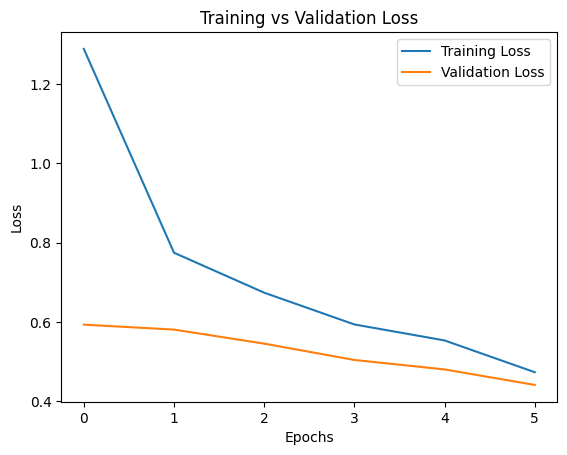

In [ ]:
# Plotting training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [ ]:
conf_matrix = confusion_matrix(y_ho, preds)

In [ ]:
print(classification_report(y_ho, preds))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1089
           1       0.95      0.76      0.84      1089

    accuracy                           0.86      2178
   macro avg       0.87      0.86      0.86      2178
weighted avg       0.87      0.86      0.86      2178



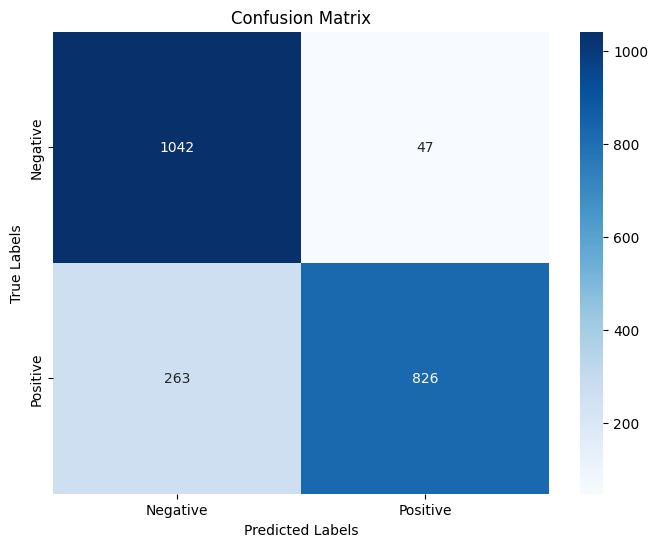

In [ ]:
class_names = ['Negative', 'Positive']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

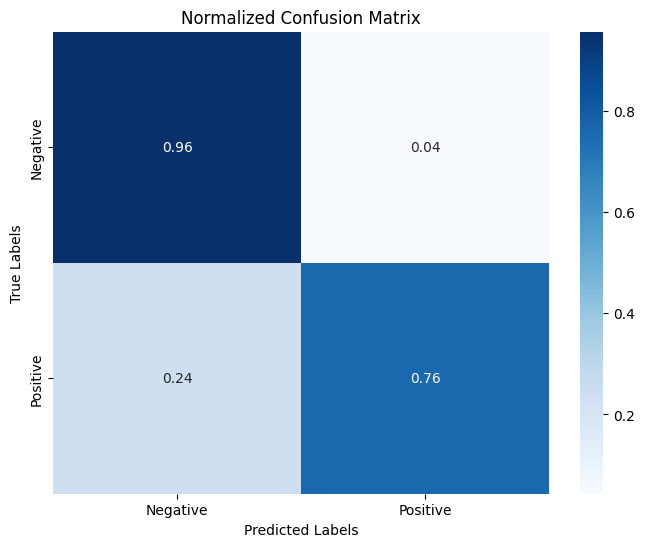

In [ ]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()